<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Guardian or Telegraph?

Sentiment analysis of article titles

---

**Objectives:**

1. Complete sentiment analysis manually using the sentiment dictionary from the lesson
2. Build a classification model to predict if the article was in The Guardian or the Telegraph
3. Evaluate your model with a classification report and confusion matrix
4. Do steps 1 to 3 using the VADER Sentiment Analyzer

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import textacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Load data

The data is in the file `brexit_articles.csv`.

The word sentiments are in the file `word_sentiments.csv`.

In [4]:
brexit = pd.read_csv('./datasets/brexit_articles.csv')
sents = pd.read_csv('./datasets/word_sentiments.csv')

In [9]:
brexit.shape

(427, 2)

In [11]:
sents.head()

,pos,word,pos_score,neg_score,objectivity,pos_vs_neg
0,ADJ,.22-caliber,0.0,0.0,1.0,0.0
1,ADJ,.22-calibre,0.0,0.0,1.0,0.0
2,ADJ,.22_caliber,0.0,0.0,1.0,0.0
3,ADJ,.22_calibre,0.0,0.0,1.0,0.0
4,ADJ,.38-caliber,0.0,0.0,1.0,0.0


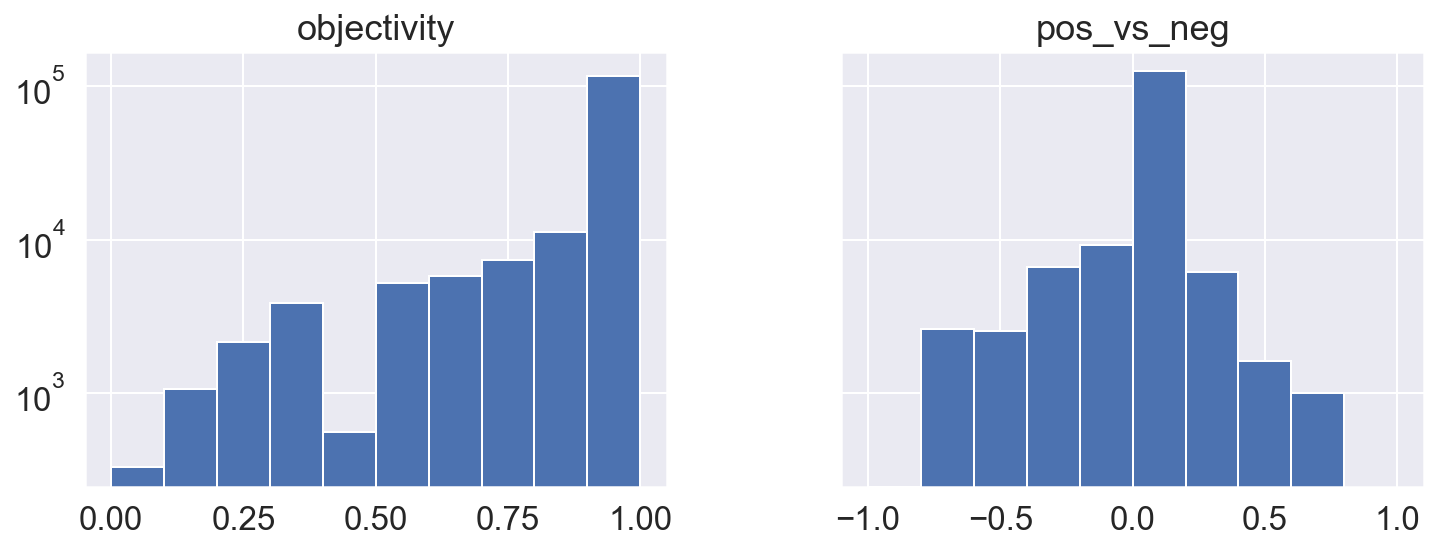

In [14]:
sents[['objectivity', 'pos_vs_neg']].hist(figsize=(12,4), sharey=True)
plt.yscale('log')
plt.show()

## Create the `sen_dict` from the word_sentiments data frame

In [17]:
from collections import defaultdict
sents_dict = defaultdict(dict) 
# set up a default dictionary with an empty dictionary as default value



In [19]:
for row in tqdm_notebook(sents.itertuples()):
    sents_dict[row.pos] [row.word] = {'objectivity': row.objectivity, 'pos_vs_neg': row.pos_vs_neg}

In [21]:
[(key, len(sents_dict[key])) for key in  sents_dict.keys()]

[('ADJ', 21479), ('NOUN', 117797), ('ADV', 4481), ('VERB', 11529)]

In [24]:
sents_dict['ADJ']['bad']

{'objectivity': 0.3214285714288999, 'pos_vs_neg': -0.6428571428569}

## Engineer an initial feature of title length

In [29]:
brexit.head()

,source,title
0,1,Sam Gyimah resigns over Theresa May's Brexit deal
1,1,SNP and Lib Dems back Benn amendment to preven...
2,1,The Guardian view on Donald Trump’s credibilit...
3,1,"In this high-stakes game of Brexit, how much o..."
4,1,Brexit: McDonnell says remain would be on ball...


# dummified one of the columns. for predicting maybe?

In [28]:
brexit = brexit[brexit.source.isin(['guardian','telegraph'])]
brexit.source = brexit.source.map(lambda x: 1 if x == 'guardian' else 0)

In [30]:
brexit["title_len"] = brexit.title.map(lambda x: len(x.split()))
brexit.shape

(427, 3)

In [32]:
brexit.head(5)

,source,title,title_len
0,1,Sam Gyimah resigns over Theresa May's Brexit deal,8
1,1,SNP and Lib Dems back Benn amendment to preven...,11
2,1,The Guardian view on Donald Trump’s credibilit...,12
3,1,"In this high-stakes game of Brexit, how much o...",16
4,1,Brexit: McDonnell says remain would be on ball...,15


## Complete sentiment analysis manually using the sentiment dictionary

In [33]:
en_nlp = textacy.load_spacy_lang('en_core_web_sm')

In [34]:
parsed = en_nlp(brexit["title"][0])

In [39]:
parsed

Sam Gyimah resigns over Theresa May's Brexit deal

In [37]:
for token in parsed:
    print(token.pos_)

PROPN
PROPN
VERB
ADP
PROPN
PROPN
PART
PROPN
NOUN


In [41]:
parsed_quotes = []
for parsed in tqdm_notebook(en_nlp.pipe(brexit['title'][:20], batch_size=50)):
    assert parsed.is_parsed
    parsed_quotes.append(parsed)

In [43]:
[(token, token.pos_) for token in parsed_quotes[0]]

[(Sam, 'PROPN'),
 (Gyimah, 'PROPN'),
 (resigns, 'VERB'),
 (over, 'ADP'),
 (Theresa, 'PROPN'),
 (May, 'PROPN'),
 ('s, 'PART'),
 (Brexit, 'PROPN'),
 (deal, 'NOUN')]

In [44]:
[(token, token.lemma_) for token in parsed_quotes[0]]

[(Sam, 'sam'),
 (Gyimah, 'gyimah'),
 (resigns, 'resign'),
 (over, 'over'),
 (Theresa, 'theresa'),
 (May, 'may'),
 ('s, "'s"),
 (Brexit, 'brexit'),
 (deal, 'deal')]

In [45]:
def process_text(documents, pos=False):
    '''
    cleans sentences from stop words and punctuation and filters by pos tags if given
    returns cleaned sentence and tokenized sentence
    '''
    nlp = textacy.load_spacy_lang('en_core_web_sm')
    
    texts = []
    tokenised_texts = []

    if pos: # pos can either be False or a list of parts of speech
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ in pos
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
    
    
    else:    
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
            
    return texts, tokenised_texts

In [63]:
brexit_text, tokenized = process_text(brexit.title, pos=False)

In [64]:
brexit_text

["Sam Gyimah resigns Theresa May 's Brexit deal",
 'SNP Lib Dems Benn amendment prevent deal Brexit',
 'The Guardian view Donald Trump ’s credibility America ’s compromised leader | Editorial',
 'In high stakes game Brexit gambler | Jonathan Freedland',
 'Brexit McDonnell says remain ballot second referendum Politics live',
 "Labour May 's Brexit deal MP Ian Austin",
 'No deal Brexit devastate UK gaming industry says report',
 'To Labour MPs want reject May ’s Brexit deal sure | Ian Austin',
 'Fully trousered typing pool | Brief letters',
 "EU dismisses May 's claim deal renegotiated PM sells Brexit G20 Politics live",
 'This means war cheesy churros destroy UK Spain relations',
 "Julian Smith chief help steer May 's Brexit Commons",
 "Owen Jones meets Keir Starmer Brexit fatigue real n't let deal pass video",
 'Northern Irish firms face 60-lorry limit Republic deal Brexit',
 'Calming cuppa lifts fortunes Fortnum & Mason',
 'A tick box terrorists May says bullocks Brexit | John Crace',

In [65]:
tokenized

[[Sam, Gyimah, resigns, Theresa, May, 's, Brexit, deal],
 [SNP, Lib, Dems, Benn, amendment, prevent, deal, Brexit],
 [The,
  Guardian,
  view,
  Donald,
  Trump,
  ’s,
  credibility,
  America,
  ’s,
  compromised,
  leader,
  |,
  Editorial],
 [In, high, stakes, game, Brexit, gambler, |, Jonathan, Freedland],
 [Brexit, McDonnell, says, remain, ballot, second, referendum, Politics, live],
 [Labour, May, 's, Brexit, deal, MP, Ian, Austin],
 [No, deal, Brexit, devastate, UK, gaming, industry, says, report],
 [To, Labour, MPs, want, reject, May, ’s, Brexit, deal, sure, |, Ian, Austin],
 [Fully, trousered, typing, pool, |, Brief, letters],
 [EU,
  dismisses,
  May,
  's,
  claim,
  deal,
  renegotiated,
  PM,
  sells,
  Brexit,
  G20,
  Politics,
  live],
 [This, means, war, cheesy, churros, destroy, UK, Spain, relations],
 [Julian, Smith, chief, help, steer, May, 's, Brexit, Commons],
 [Owen,
  Jones,
  meets,
  Keir,
  Starmer,
  Brexit,
  fatigue,
  real,
  n't,
  let,
  deal,
  pass,
 

In [66]:
pos = ['NOUN', 'ADJ', 'VERB', 'ADV']

In [67]:
process_text(brexit['title'][:2], pos=pos)

(['resigns deal', 'amendment prevent deal Brexit'],
 [[resigns, deal], [amendment, prevent, deal, Brexit]])

In [68]:
process_text

<function __main__.process_text(documents, pos=False)>

In [69]:
processed_quotes, tokenised_quotes = process_text(brexit['title'], pos=pos)

In [70]:
brexit['processed_quote'] = processed_quotes
brexit['tokenised_quotes'] = tokenised_quotes

In [71]:
brexit.head()

,source,title,title_len,processed_quote,tokenised_quotes
0,1,Sam Gyimah resigns over Theresa May's Brexit deal,8,resigns deal,"[resigns, deal]"
1,1,SNP and Lib Dems back Benn amendment to preven...,11,amendment prevent deal Brexit,"[amendment, prevent, deal, Brexit]"
2,1,The Guardian view on Donald Trump’s credibilit...,12,view credibility compromised leader Editorial,"[view, credibility, compromised, leader, Edito..."
3,1,"In this high-stakes game of Brexit, how much o...",16,high stakes game gambler,"[high, stakes, game, gambler]"
4,1,Brexit: McDonnell says remain would be on ball...,15,Brexit says remain ballot second referendum Po...,"[Brexit, says, remain, ballot, second, referen..."


In [72]:
def scorer(parsed):
    """
    Determines the average objectivity and positive-versus-negative scores 
    for a given sentence
    """
   
    obj_scores, pvn_scores = [], []
    for token in parsed:
        try:
            obj_scores.append(sen_dict[token.pos_][token.lemma_]['objectivity'])
            pvn_scores.append(sen_dict[token.pos_][token.lemma_]['pos_vs_neg'])
        except:
            pass
        
    # set default values if no token found
    if not obj_scores:
        obj_scores = [1.]
    if not pvn_scores:
        pvn_scores = [0.]
        
    return [np.mean(obj_scores), np.mean(pvn_scores)]

In [73]:
scores = brexit['tokenised_quotes'].map(scorer)

In [74]:
brexit['objectivity_avg'] = scores.map(lambda x: x[0])
brexit['polarity_avg'] = scores.map(lambda x: x[1])

In [75]:
brexit.sort_values("polarity_avg").tail().iloc[:10,:]

,source,title,title_len,processed_quote,tokenised_quotes,objectivity_avg,polarity_avg
137,1,"Trump blasts GM over job cuts, as deeper trade...",14,blasts job cuts deeper trade war looms busines...,"[blasts, job, cuts, deeper, trade, war, looms,...",1.0,0.0
136,1,"Trump blasts GM over job cuts, as deeper trade...",15,blasts job cuts deeper trade war looms happened,"[blasts, job, cuts, deeper, trade, war, looms,...",1.0,0.0
135,1,Labour plan to give customers of big firms vot...,12,Labour plan customers big firms vote boardroom...,"[Labour, plan, customers, big, firms, vote, bo...",1.0,0.0
133,1,Gentleman and Cadwalladr win joint journalist ...,10,win joint journalist year award,"[win, joint, journalist, year, award]",1.0,0.0
426,0,Northern Ireland hospitality trade poll backs ...,16,hospitality trade poll backs draft deal bodies...,"[hospitality, trade, poll, backs, draft, deal,...",1.0,0.0


In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [77]:
X = brexit[["objectivity_avg","polarity_avg"]].astype(float)
y = brexit.source

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

lr = LogisticRegression(solver='liblinear')
lr.fit(Xs, y)

scores = cross_val_score(lr, Xs, y, cv=10)
print(scores)
print(np.mean(scores))


[0.65116279 0.65116279 0.65116279 0.65116279 0.65116279 0.65116279
 0.65116279 0.64285714 0.64285714 0.64285714]
0.6486710963455151


## Build a classification model to predict if the article was in The Guardian or the Telegraph

I am using a Random Forest Model, but if you have time do try others!!

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [ ]:
y = 

In [ ]:
X =

## Evaluate your model with a classification report and confusion matrix

Describe your results!

## Do steps 1 to 3 using the VADER Sentiment Analyzer

### Complete sentiment analysis using VADER

### Build a classification model to predict if the article was in The Guardian or the Telegraph

### Evaluate your model with a classification report and confusion matrix

Describe your results!